<a href="https://colab.research.google.com/github/Victorrani/synoptic_maps/blob/main/gfs025_testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Creating maps based on (copies of) the website https://www.atmos.albany.edu/student/abentley/realtime.html
###just for training

###Installing the necessary libraries for the maps.
###Need to observe possible version errors

In [ ]:
##instalar as biblitecas
!pip install pygrib

In [ ]:
!pip install numpy==1.23

  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1


In [ ]:
!pip install cartopy
!pip install shapely --no-binary shapely --force

  Using cached shapely-2.0.1-cp310-cp310-linux_x86_64.whl
  Using cached numpy-1.25.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.1 which is incompatible.


In [ ]:
!pip install metpy

In [ ]:
!pip install xarray

In [ ]:
!pip install cfgrib
!pip install ecCodes
!pip install netcdf4 h5netcdf

In [ ]:
!pip install eccodes

###All libraries used in the script

In [ ]:
import sys
import pygrib
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import pandas as pd
from metpy.calc import reduce_point_density
from metpy.io import metar
from metpy.plots import current_weather, sky_cover, StationPlot
import metpy.plots as mpplots
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from google.colab import drive
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import netCDF4
import metpy



###File in grib2 format stored on googledrive

In [ ]:
##open file

drive.mount('/content/drive')

arquivo = '/content/drive/MyDrive/gfs025.202304200000_000.grb2'

gfs = pygrib.open(arquivo)
gfs

Mounted at /content/drive


###Download the file of the states of Brazil

In [ ]:
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
!unzip -o br_unidades_da_federacao.zip

--2023-07-25 15:00:56--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10912177 (10M) [application/zip]
Saving to: ‘br_unidades_da_federacao.zip’

br_unidades_da_fede 100%[===================>]  10.41M  8.98MB/s    in 1.2s    

2023-07-25 15:00:58 (8.98 MB/s) - ‘br_unidades_da_federacao.zip’ saved [10912177/10912177]

Archive:  br_unidades_da_federacao.zip
 extracting: BR_UF_2019.cpg          
  inflating: BR_UF_2019.dbf          
  inflating: BR_UF_2019.prj          
  inflating: BR_UF_2019.shp          
  inflating: BR_UF_2019.shx          


###Selecting region of Brazil on the Map. A next version can be chosen anywhere in the world

In [173]:
regiao = [-120, 0, -60, 15]

In [174]:
def latlon(lista):

  regiao = lista
  x_min, x_max = regiao[0], regiao[1]
  y_min, y_max = regiao[2], regiao[3]
##Define de onde até onde a marcação vai com passos definidos
  x_ticks = np.arange(x_min, x_max + 1, 20)
  y_ticks = np.arange(y_min, y_max + 1, 10)
##condição
  y_ticklabels = [f'{abs(tick)}° S' if tick < 0 else f'{tick}° N' if tick > 0 else '0' for tick in y_ticks]
  x_ticklabels = [f'{abs(tick)}° W' if tick < 0 else f'{tick}° E' if tick > 0 else '0' for tick in x_ticks]

  ax.set_xticks(x_ticks)
  ax.set_yticks(y_ticks)

  ax.set_xticklabels(x_ticklabels)
  ax.set_yticklabels(y_ticklabels)




### PLOT 1 Using pygrib

In [179]:
f = open("variables.txt", "w")
for variables in gfs:
    # Print the variables in the terminal
    print(variables)
    # Put the variables in the text file
    print(variables, file=f)
f.close()


In [ ]:
titulo = 'MSLP (black, hPa), 1000 - 500 thickness (red/blue, dam), 250 hPa wind speedy (shaded, m/s)\nGFS 0.25 2023/04/02 00Z'

In [ ]:
##select variables

select_u250 = gfs.select(name='U component of wind', typeOfLevel='isobaricInhPa', level=250)[0]
select_v250 = gfs.select(name='V component of wind', typeOfLevel='isobaricInhPa', level=250)[0]

u250, lats, lons = select_u250.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
v250, lats, lons = select_v250.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_geo500=gfs.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 500)[0]
select_geo1000=gfs.select(name='Geopotential Height', typeOfLevel='isobaricInhPa', level=1000)[0]

geo500, lats, lons = select_geo500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
geo1000, lats, lons = select_geo1000.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_pmsl=gfs.select(name='Pressure reduced to MSL')[0]
pmsl, lats, lons = select_pmsl.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

#deal with the variables
pmsl = pmsl / 100
deltageo = (geo500 - geo1000) / 10
mag250 = np.sqrt((u250*u250)+(v250*v250))

In [ ]:
##função que trata o dado suaviza a onda

pmsl = ndimage.gaussian_filter(pmsl, sigma=5, order=0)
mag250 = ndimage.gaussian_filter(mag250, sigma=5, order=0)
deltageo = ndimage.gaussian_filter(deltageo, sigma=5, order=0)

In [ ]:
##Create colormap

colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0), (1, 1, 1)]
cmap_name = 'custom_blue_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

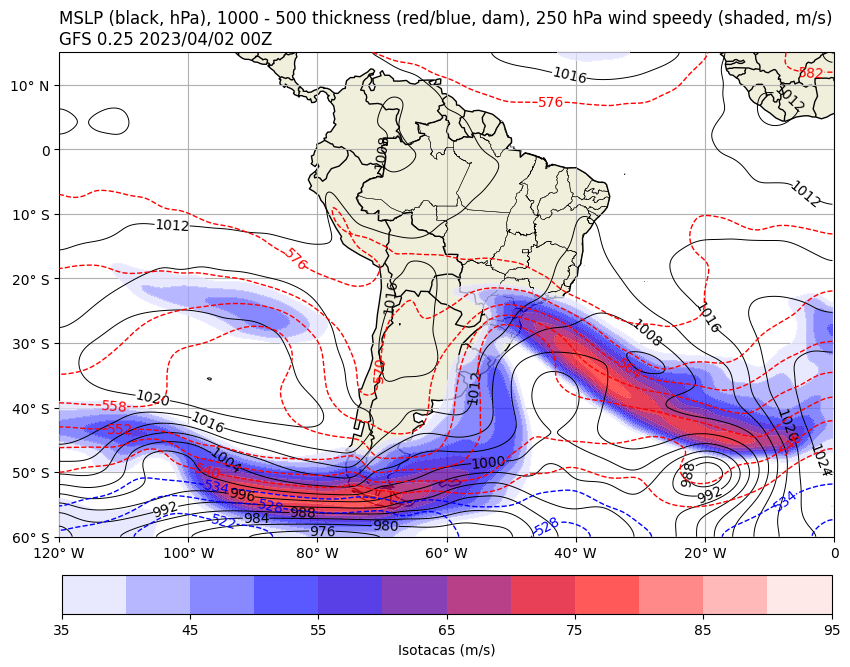

In [170]:
fig = plt.figure(figsize=(10,10))

##Criação do mapa com o projeção
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(regiao, crs=ccrs.PlateCarree())

##Funcionalidades do mapa
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

##Coloca os estados brasileiros no mapa
shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.3, zorder=300)

##Jatos de altos níveis
data_min = 35
data_max = 100
interval = 5
levels = np.arange(data_min,data_max,interval)


img1 = ax.contourf(lons, lats, mag250,cmap=cm, levels=levels,vmin=35,  transform=ccrs.PlateCarree(), zorder=300, alpha=0.75)
img2 = ax.contour(lons, lats, mag250, colors='white', linewidths=0.2, levels=levels, transform=ccrs.PlateCarree(), zorder=301)
plt.colorbar(img1, label='Isotacas (m/s)', orientation='horizontal', pad=0.05, fraction=0.05)

##pmsl
data_min_pmsl = 840
data_max_pmsl = 1200
interval_pmsl = 4
levels_pmsl = np.arange(data_min_pmsl, data_max_pmsl,interval_pmsl)


img3 = ax.contour(lons, lats, pmsl, colors='black', linewidths=0.7, levels=levels_pmsl, zorder=305)
ax.clabel(img3, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')

##espessura da camada <540dam
data_min_espessura = 0
data_max_espessura = 540
interval_espessura = 6
levels = np.arange(data_min_espessura ,data_max_espessura ,interval_espessura)


img4 = ax.contour(lons, lats, deltageo, colors='blue', linestyles='dashed', linewidths=1, levels=levels, zorder=306)
ax.clabel(img4, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'blue')

##espessura da camada >540dam
data_min_espessura2 = 540
data_max_espessura2 = 1000
interval_espessura2 = 6
levels = np.arange(data_min_espessura2,data_max_espessura2,interval_espessura2)


img5 = ax.contour(lons, lats, deltageo, colors='red', linestyles='dashed', linewidths=1, levels=levels, zorder=307)
ax.clabel(img5, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors='red')


##função que define o grid da figura com relação ao que foi definido marcadores de lat lon
latlon(regiao)

ax.grid()

plt.title(titulo, loc='left')

plt.show()

###Using Xarray

In [ ]:
####em pesquisa

### PLOT 2 (teste)

In [ ]:
titulo500 = '500 hPa geo height (black, dam), Temp (red, C)\nAscending speed (blue, 5*10^-3), rel vort (x10^⁻5 s^⁻1) wind(barbs ms^-1)\nGFS 0.25 2023/04/02 00Z'

In [ ]:
select_u500=gfs.select(name='U component of wind', typeOfLevel='isobaricInhPa', level=500)[0]
select_v500=gfs.select(name='V component of wind', typeOfLevel='isobaricInhPa', level=500)[0]

u500, lats, lons = select_u500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
v500, lats, lons = select_v500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_geo500=gfs.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 500)[0]
geo500, lats, lons = select_geo500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_temp500=gfs.select(name='Temperature', typeOfLevel = 'isobaricInhPa', level = 500)[0]
temp500, lats, lons = select_temp500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)


select_ascent500=gfs.select(name='Vertical velocity', typeOfLevel='isobaricInhPa', level=500)[0]
ascent500, lats, lons = select_ascent500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_vortice500=gfs.select(name='Absolute vorticity', typeOfLevel='isobaricInhPa', level=500)[0]
vortice500, lats, lons = select_vortice500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

geo500 = geo500 / 10
ascent500 = ( ascent500 / 100 )
mag500 = np.sqrt((u500*u500)+(v500*v500))


	##cria o contorno das linhas arredondado, suavizado
geo500 = ndimage.gaussian_filter(geo500, sigma=5, order=0)
mag500 = ndimage.gaussian_filter(mag500, sigma=5, order=0)
temp500 = ndimage.gaussian_filter(temp500, sigma=5, order=0)

In [ ]:
print(geo500)

[[585.94403195 585.94662582 585.95169287 ... 589.4551223  589.45329021
  589.45228946]
 [585.94620634 585.94875596 585.95373455 ... 589.45271398 589.45056325
  589.44939959]
 [585.95035134 585.952815   585.9576216  ... 589.44771004 589.44495003
  589.4434751 ]
 ...
 [516.91167761 516.93121555 516.96910079 ... 543.02373329 542.98995078
  542.97252318]
 [516.6708126  516.6900409  516.72732002 ... 542.93266171 542.89903689
  542.88169425]
 [516.54848863 516.56755212 516.60450871 ... 542.88634503 542.8528073
  542.83551144]]


In [ ]:
print(temp500.max())

272.0563568553664


In [ ]:
temp500 = temp500*units('K')


In [ ]:
temp500 = temp500.to(units.degC)

In [ ]:
print(temp500.max())

-1.0936431446335746 degree_Celsius


In [ ]:
u500 = units('m/s')*u500
v500 = units('m/s')*v500
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
vortice_500 = mpcalc.vorticity(u500, v500, dx=dx, dy=dy)




In [ ]:
colors = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
cmap_name = 'custom_red_yellow_white'
cm1 = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

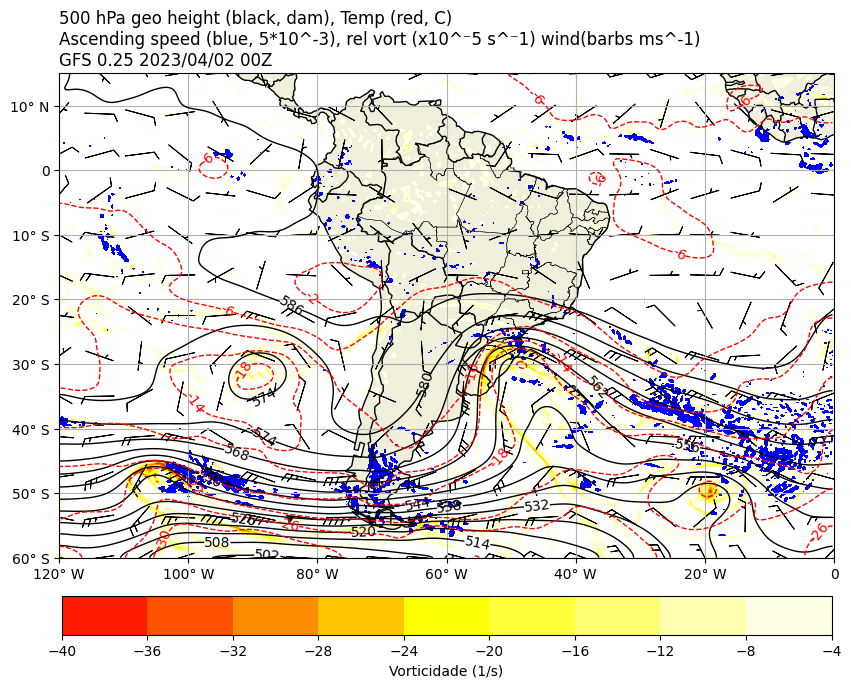

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(regiao, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.3, zorder=300)


data_min_geo = 400
data_max_geo = 700
interval_geo = 6
levels_geo = np.arange(data_min_geo ,data_max_geo ,interval_geo)

##Plot the geopotencial height
img1 = ax.contour(lons, lats, geo500, colors='black', linewidths=1, levels=levels_geo, zorder=305)
ax.clabel(img1, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')

data_min_temp = -50
data_max_temp = 0
interval_temp = 4
levels_temp = np.arange(data_min_temp, data_max_temp, interval_temp)

##temperatura
img2 = ax.contour(lons, lats, temp500, colors='red', linewidths=1, levels=levels_temp, zorder=306)
ax.clabel(img2, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'red')

##plot rel vort
data_min_vort = -40
data_max_vort = 0
interval_vort = 4
levels_vort = np.arange(data_min_vort, data_max_vort, interval_vort)

img2 = ax.contourf(lons, lats, vortice_500*10**5, cmap=cm1, levels=levels_vort)
plt.colorbar(img2, label='Vorticidade (1/s)', orientation='horizontal', pad=0.05, fraction=0.05)

##plot vertical speedy
data_min_ascent = ascent500.min()
data_max_ascent = 0
interval_ascent = 0.01
levels_ascent = np.arange(data_min_ascent, data_max_ascent, interval_ascent)

img3 = ax.contourf(lons, lats, ascent500, colors='blue', levels=levels_ascent)

##wind_barbs

# Create a flag to determine which barbs are flipped
flip_flag = np.zeros((u500.shape[0],v500.shape[1]))

# All flags below the equator will be flipped
flip_flag[lats < 0] = 1

img4 = ax.barbs(lons[::25,::25],
                lats[::25,::25],
                u500[::25,::25],
                v500[::25,::25],
                sizes=dict(emptybarb=0.0, spacing=0.2, height=0.25),
                linewidth=0.7,
                length=6.5,
                pivot='middle',
                barbcolor='black',
                flip_barb = flip_flag[::25,::25])

##função que define o grid da figura com relação ao que foi definido marcadores de lat lon
latlon(regiao)

ax.grid()

plt.title(titulo500, loc='left')

plt.show()

grafico 3

In [ ]:
select_temp850=gfs.select(name='Temperature', typeOfLevel = 'isobaricInhPa', level = 850)[0]
temp850, lats, lons = select_temp500.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_relatUmi850=gfs.select(name='Relative humidity', typeOfLevel = 'isobaricInhPa', level = 850)[0]
relatUmi850, lats, lons = select_relatUmi850.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_geo850=gfs.select(name='Geopotential Height', typeOfLevel = 'isobaricInhPa', level = 850)[0]
geo850, lats, lons = select_geo850.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)

select_u850=gfs.select(name='U component of wind', typeOfLevel='isobaricInhPa', level=850)[0]
select_v850=gfs.select(name='V component of wind', typeOfLevel='isobaricInhPa', level=850)[0]

u850, lats, lons = select_u850.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)
v850, lats, lons = select_v850.data(lat1=regiao[2],lat2=regiao[3],lon1=regiao[0]+360,lon2=regiao[1]+360)







In [ ]:
print(geo850)

[[1491.3780625 1491.4420625 1491.1700625 ... 1513.0100625 1512.0340625
  1510.7700625]
 [1491.1060625 1491.3140625 1491.0580625 ... 1512.5780625 1511.9380625
  1510.9460625]
 [1490.7220625 1490.9140625 1490.8340625 ... 1512.3060625 1511.7460625
  1511.0100625]
 ...
 [1167.5860625 1169.9060625 1171.8420625 ... 1432.2420625 1432.4660625
  1432.6100625]
 [1165.1060625 1167.1380625 1169.0100625 ... 1430.4980625 1430.8180625
  1431.0580625]
 [1162.8020625 1164.5780625 1166.3540625 ... 1428.7220625 1429.0260625
  1429.2500625]]


In [ ]:

geo850 = geo850 / 10

print(geo850)


[[149.13780625 149.14420625 149.11700625 ... 151.30100625 151.20340625
  151.07700625]
 [149.11060625 149.13140625 149.10580625 ... 151.25780625 151.19380625
  151.09460625]
 [149.07220625 149.09140625 149.08340625 ... 151.23060625 151.17460625
  151.10100625]
 ...
 [116.75860625 116.99060625 117.18420625 ... 143.22420625 143.24660625
  143.26100625]
 [116.51060625 116.71380625 116.90100625 ... 143.04980625 143.08180625
  143.10580625]
 [116.28020625 116.45780625 116.63540625 ... 142.87220625 142.90260625
  142.92500625]]


In [ ]:
geo850 = ndimage.gaussian_filter(geo850, sigma=5, order=0)

In [ ]:
print(geo850)

[[585.98203425 585.98354257 585.98654507 ... 589.42892892 589.42713938
  589.42621843]
 [585.98231157 585.98378714 585.98672464 ... 589.42579507 589.4239133
  589.42294557]
 [585.98279777 585.98420824 585.98701649 ... 589.41945038 589.41738888
  589.41633001]
 ...
 [518.32463314 518.33571275 518.35742165 ... 543.6177826  543.59965215
  543.59039417]
 [518.14142024 518.15245167 518.17406524 ... 543.54981808 543.53160998
  543.52231343]
 [518.04899587 518.06000164 518.08156445 ... 543.51553704 543.49729111
  543.48797578]]


In [ ]:
print(temp850)


[[268.12275391 268.27275391 268.05275391 ... 266.44275391 266.46275391
  266.17275391]
 [268.13275391 268.28275391 268.12275391 ... 266.49275391 266.26275391
  266.10275391]
 [268.21275391 268.34275391 268.21275391 ... 266.46275391 266.19275391
  266.14275391]
 ...
 [243.37275391 243.73275391 243.93275391 ... 246.10275391 245.97275391
  245.80275391]
 [242.68275391 242.97275391 243.44275391 ... 246.09275391 246.01275391
  245.88275391]
 [243.02275391 243.19275391 243.44275391 ... 246.10275391 246.03275391
  245.91275391]]


In [ ]:
print(relatUmi850)

[[23.4 29.3 28.2 ...  7.5  7.4  7.1]
 [21.4 25.  26.8 ...  7.2  7.1  7. ]
 [23.4 25.9 27.5 ...  7.1  6.9  6.7]
 ...
 [96.6 96.2 95.6 ... 28.1 29.4 32.7]
 [95.8 95.1 94.2 ... 28.4 28.7 31.2]
 [94.3 93.2 93.1 ... 28.9 29.  30.3]]


In [ ]:
temp850 = units('K')*temp850
relatUmi850 = units('percent')*relatUmi850 /100

In [ ]:
temp850 = temp500.to(units.degC)

In [ ]:
print(relatUmi850)
print(temp850)

[[0.234 0.293 0.28200000000000003 ... 0.075 0.07400000000000001  0.07100000000000001] [0.21400000000000002 0.25 0.268 ... 0.07200000000000001  0.07100000000000001 0.07] [0.234 0.259 0.275 ... 0.07100000000000001 0.069 0.067] ... [0.9660000000000001 0.9620000000000001 0.9560000000000001 ... 0.281  0.29400000000000004 0.327] [0.9580000000000001 0.9510000000000001 0.9420000000000001 ...  0.28400000000000003 0.28700000000000003 0.31200000000000006] [0.9430000000000001 0.932 0.931 ... 0.28900000000000003 0.29 0.303]] percent
[[-5.0299493559495545 -5.028735137013541 -5.026189525254495 ...  -6.498199869081702 -6.4946808115851695 -6.492950968960372] [-5.013536352415883 -5.012212468074267 -5.009469298227941 ...  -6.484802269902673 -6.481505924085468 -6.479894114398348] [-4.981709892403501 -4.98019193775275 -4.977100448145961 ...  -6.460241505980434 -6.457405879493422 -6.456037447008271] ... [-27.595476861650013 -27.563410737509344 -27.50093346561306 ...  -26.816239057490293 -26.844365401845323 

In [ ]:
dew_pt = mpcalc.dewpoint_from_relative_humidity(temp850, relatUmi850)




In [ ]:
print(dew_pt)

[[-64.9693110691565 -63.28727228077673 -63.574191623518516 ...  -73.76987663826702 -73.85789983553067 -74.13337248857948] [-65.61958752874969 -64.46801548478118 -63.94702514948946 ...  -74.0359112872842 -74.12752802484275 -74.22122634787718] [-64.94227531663608 -64.18606284519518 -63.73523319308316 ...  -74.1166696816017 -74.30554266223038 -74.50032024333672] ... [-68.36950893944834 -68.37799159762329 -68.3815063698811 ...  -76.2859838349259 -76.00838249050008 -75.3206172078479] [-68.53351109124912 -68.56372277285828 -68.58858854306834 ...  -76.21928431726914 -76.16808311243699 -75.63168447588114] [-68.69943540274065 -68.76035391784967 -68.72439186452038 ...  -76.10692200796353 -76.10180468890462 -75.82469807110019]] degree_Celsius


In [ ]:
temp_equi_poten = mpcalc.equivalent_potential_temperature(850*units.hPa, temp850, dew_pt)


In [ ]:
temp_equi_poten = temp_equi_poten.magnitude

In [ ]:
print(temp_equi_poten.min())
print(temp_equi_poten.max())

250.71911753471926
285.0689084909767


In [ ]:
colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0), (1, 1, 1)]
cmap_name = 'custom_blue_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

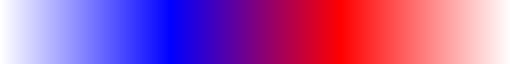

In [ ]:
cm

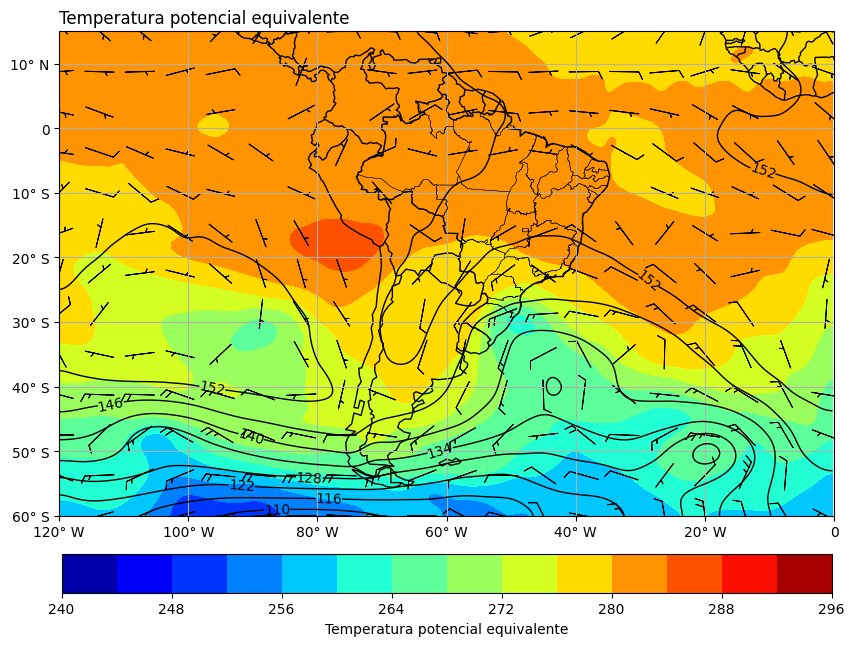

In [167]:
titulo850='Temperatura potencial equivalente'

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(regiao, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

shapefile = list(shpreader.Reader('BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.3, zorder=300)

data_min_temp = 240
data_max_temp = 300
interval_temp = 4
levels_temp = np.arange(data_min_temp ,data_max_temp ,interval_temp)

##Plot the geopotencial height
img1 = ax.contourf(lons, lats, temp_equi_poten, cmap='jet', levels=levels_temp)
plt.colorbar(img1, label='Temperatura potencial equivalente', orientation='horizontal', pad=0.05, fraction=0.05)
#ax.clabel(img1, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')



flip_flag[lats < 0] = 1

img2 = ax.barbs(lons[::25,::25],
                lats[::25,::25],
                u850[::25,::25],
                v850[::25,::25],
                sizes=dict(emptybarb=0.0, spacing=0.2, height=0.25),
                linewidth=0.7,
                length=6.5,
                pivot='middle',
                barbcolor='black',
                flip_barb = flip_flag[::25,::25])

data_min_geo = 110
data_max_geo = 200
interval_geo = 6
levels_geo = np.arange(data_min_geo ,data_max_geo ,interval_geo)

##Plot the geopotencial height
img3 = ax.contour(lons, lats, geo850, colors='black', linewidths=1, levels=levels_geo, zorder=310)
ax.clabel(img3, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'black')

latlon(regiao)

ax.grid()

plt.title(titulo850, loc='left')

plt.show()
